# Finding forever homes: Predicting animal shelter outcomes

## Abstract

What determines whether or not an animal gets adopted?  Does their breed or coat color matter?  If they have a name? The time of the year?  Do determinants vary between cats and dogs? 

For this project, I utilized Random Forest and Support Vector Machine models to predict animal shelter outcomes using data from the Austin Animal Center.  The accuracy of Random Forest in predict whether or not an animal is adopted is 0.849 for cats and 0.704 in dogs. Whether or not the animal is fixed and the age of the animal are significant predictors for adoption in cats and dogs.  Breed is more important for dogs and having a name is more important for cats in predicting adoptions.  I employed grid search to identify good ($C$, $\gamma$) parameters for the SVM model.  Grid search improved the accuracy scores of SVM considerably, from 0.577 to 0.837 in the cat model and 0.55 to 0.817 in the dog model.  

Powerpoint presentation for this project can be found [here](https://docs.google.com/presentation/d/1SyTUL4NVHKP0Fx1SwaFzFv58HX376mJbA9vlrTe9KxY/edit?usp=sharing).


# Table of Contents
- [Introduction](#intro)
    - Research Questions
    - Model descriptions
- [Imports](#imports)
- [Uploading and Describing data](#data)
- [Exploratory Data Analysis](#explore)
- [Feature Engineering](#features)
- [Models](#models)
    - [Adoption Decision Tree](#tree)
    - [Outcome Random Forest](#foresto)
    - [Adoption Random Forest](#foresta)
    - [Support Vector Machine Classifer](#svc)
    - [SVM with Grid Search](#grid)
- [Conclusion](#conclusion)

<a id='intro'></a>
# Introduction
According to the American Society for the Prevention of Cruelty to Animals ([ASPCA](https://www.aspca.org/animal-homelessness/shelter-intake-and-surrender/pet-statistics)), approximately 6.5 million animals, the vast majority being cats and dogs, enter US animal shelters nationwide every year. Fortunately, the number of animals that are euthanized annually is declining, from 2.6 million in 2011 to 1.5 million according to recent estimates.  This decline may be due to the increase in pet adoptions, runaways being successfully returned to their owners, and programs such as Trap, Neuter, Release that returns spayed/neutered stray cats back to their environments.

So what factors go into whether or not an animal is adopted?  In this project, I will be building models that incorporates various features to predict animal shelter outcomes.

I will be using data from the Austin Animal Center, the largest no-kill animal shelter in the United States.  This dataset contains animal shelter outcomes on 78,255 animals, among them 44,242 dogs and 29,422 cats.  Along with the adoption end outcomes, the datset tracks animal transfers, deaths, euthanasia, returns to their owners, and others.

## Research Questions
I will be attempting to answer the following questions.
- What features are the best determinants for animal shelter outcomes?
- What features are the best determinants for whether or not the animal is adopted?
- Do those features differ between cats and dogs?

## Models
To answer these questions, I will be using decision trees, random forests, and support vector machines.


<a id='imports'></a>

# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Keeping track of runtime.
import timeit

# Decision trees
from sklearn import tree
from IPython.display import Image

# Packages for rendering tree.
import pydotplus
import graphviz

# Random Forest
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Confusion matrix
from sklearn.metrics import confusion_matrix

# Support Vector Machine
from sklearn.svm import SVC

# Label Encoder
from sklearn.preprocessing import LabelEncoder

#Stylings
sns.set(style="white", color_codes=True)

<a id='data'></a>
# Uploading and describing data

In [2]:
raw_data = pd.read_csv('datafiles/aac_shelter_outcomes.csv')
raw_data.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78256 entries, 0 to 78255
Data columns (total 12 columns):
age_upon_outcome    78248 non-null object
animal_id           78256 non-null object
animal_type         78256 non-null object
breed               78256 non-null object
color               78256 non-null object
date_of_birth       78256 non-null object
datetime            78256 non-null object
monthyear           78256 non-null object
name                54370 non-null object
outcome_subtype     35963 non-null object
outcome_type        78244 non-null object
sex_upon_outcome    78254 non-null object
dtypes: object(12)
memory usage: 7.2+ MB


In [4]:
raw_data.nunique()

age_upon_outcome       46
animal_id           70855
animal_type             5
breed                2128
color                 525
date_of_birth        5869
datetime            64361
monthyear           64361
name                14574
outcome_subtype        19
outcome_type            9
sex_upon_outcome        5
dtype: int64

## Duplicates

I noticed that there are more entries than animal ids.  This indicates that some animals have been at the shelter more than once.  Let's pull those duplicates out of the dataset and take a look at what's going on.

In [5]:
dupes = pd.concat(g for _, g in raw_data.groupby("animal_id") if len(g) > 1)

In [6]:
dupes.animal_id.nunique()

5865

There are 5,865 animals with multiple entries in the dataset. With a total of 13,266 rows, these animals take up almost 17% of the dataset.  That's a lot!

Just taking a cursory look at the data, a lot of the animals that have multiple entries are runaways.  Scamp, appropriately named, has ran away and been returned to his owner three times over the course of three years.  Some animals have multple adoptions.  Toby, for example, was adopted in December of 2013 and again in July of 2015.  Others have multiple outcomes at different times.  Huey was adopted July of 2015 and was sadly euthanized due to suffering less than a year later in May of 2016.

Let's take a look at the outcome value counts for the animal duplicates. 

In [7]:
dupes.outcome_type.value_counts()

Adoption           6855
Return to Owner    4407
Transfer           1693
Euthanasia          238
Rto-Adopt            43
Died                 14
Missing               7
Disposal              4
Name: outcome_type, dtype: int64

While it makes sense for animals that have been adopted multiple times or have experience different outcomes to have more than one row of information, chronic runaways may skew our data when we are trying to predict outcomes.  I believe the best option is to remove occurences of multiple Return to Owners of the same pet.

In [8]:
raw_data.drop_duplicates(subset=['animal_id','outcome_type'], keep='first', inplace=True)

In [9]:
# Check to see if Scamp still has multiple entries
raw_data[raw_data['name']=='Scamp']

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
6968,6 years,A006100,Dog,Spinone Italiano Mix,Yellow/White,2007-07-09T00:00:00,2014-03-08T17:10:00,2014-03-08T17:10:00,Scamp,NaN,Return to Owner,Neutered Male


<a id='explore'></a>
# Exploratory Data Analysis

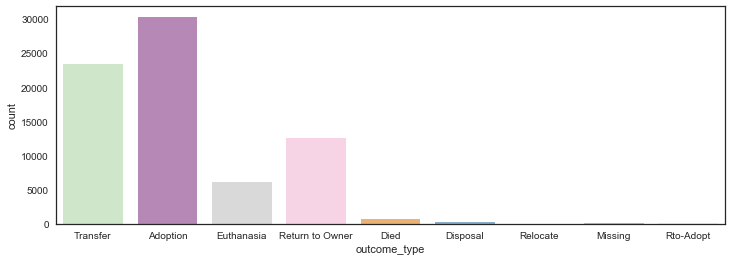

In [10]:
plt.figure(figsize=(12,4))
sns.countplot(x='outcome_type', data=raw_data, palette='Set3_r')

Hooray! Adoption is the most common outcome at this shelter, followed by Transfer and Return to Owner. Since some categories are very rare (Died, Disposal, Relocate, Missing, Rto-Adopt), there is a class imbalance issue.  Thus, it may be difficult to predict these rarer outcomes.  That is something to consider in the modeling to predict for the different outcome categories.  It should not be an issue when I consider adoption as a binary outcome (Adopt or not adopt).

Let's look at the outcome subtypes.

In [11]:
raw_data.groupby(['outcome_type','outcome_subtype']).size()

outcome_type  outcome_subtype    
Adoption      Barn                       1
              Foster                  5323
              Offsite                  340
Died          At Vet                    33
              Enroute                   45
              In Foster                164
              In Kennel                335
              In Surgery                16
Euthanasia    Aggressive               506
              At Vet                    26
              Behavior                 142
              Court/Investigation       18
              Medical                  259
              Rabies Risk             2414
              Suffering               2512
              Underage                  28
Missing       In Foster                 18
              In Kennel                  8
              Possible Theft             8
Transfer      Barn                       2
              Partner                19588
              SCRP                    3132
              Snr   

We can see that each outcome is broken out into subtypes.  It should be noted that outcome types without a listed subtype is not included in this table.  Adoptions with the subtype NA is not included, for example.  Neither are Return to Owner outcomes.

Because Austin Animal shelter is no-kill, they employ many programs in conjunction with community members and organizations to reduce euthanisia due to space limitations and ensure the animals are living in safe environments.  Two of such programs are
1. SCRP is Austin Animal Shelter's Stray Cat Release program. This is similar to Trap, Neuter, Release (TNR), in that stray cats and spayed/neutered and returned to their environment.  You can find more information on this service [here](http://www.maddiesfund.org/austin-animal-services-stray-cat-return-program.htm).
2. Shelter Neuter Release (Snr) is also similar to TNR.  You can find more information on this program [here](http://www.austintexas.gov/blog/changes-made-shelter-neuter-return-cat-program-reflect-community-stakeholder-input).

While I do not plan to use outcome subtypes in this project, it would definitely be interesting to consider in future analysis.

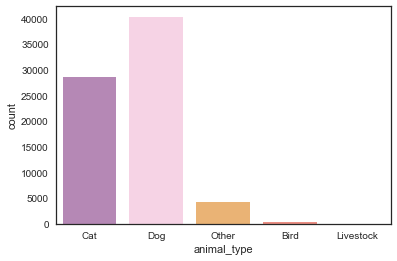

In [12]:
sns.countplot(x='animal_type', data=raw_data, palette='Set3_r')

Most of the animals in the dataset are either cats or dogs.  

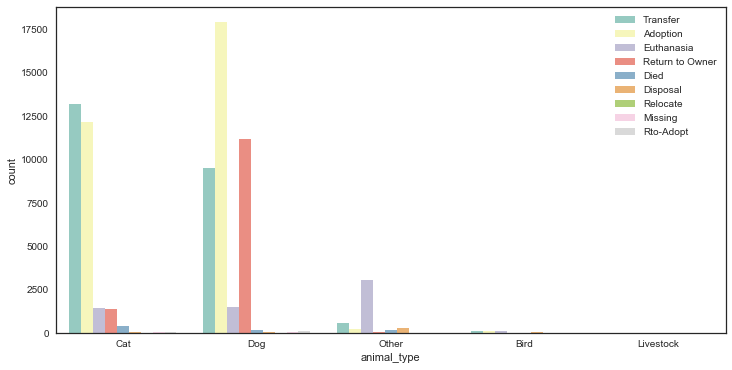

In [13]:
plt.figure(figsize=(12,6))
sns.countplot(data=raw_data,
              x='animal_type',
              hue='outcome_type',
              palette='Set3')
plt.legend(loc='upper right')
plt.show()

<a id='sexvoutcome'></a>

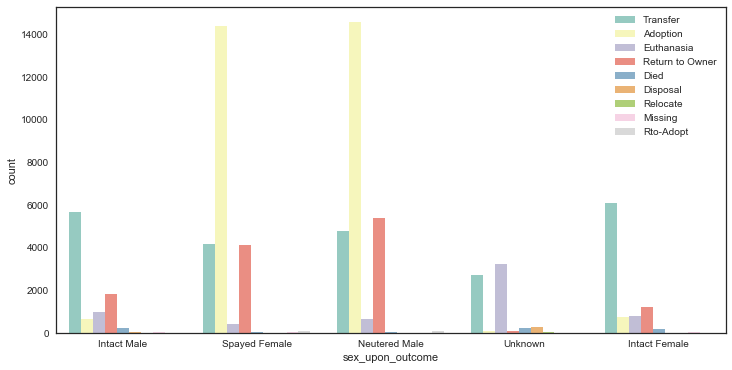

In [14]:
plt.figure(figsize=(12,6))
sns.countplot(data=raw_data,
              x='sex_upon_outcome',
              hue='outcome_type',
              palette='Set3')
plt.legend(loc='upper right')
plt.show()

If we look at the outcome broken out by sex, we see that neutered and spayed animals are much more likely to be adopted.  There is a bit of a chicken-egg issue there.  Are the animals adopted because they are fixed, or do they get fixed once they are adopted?  Nevertheless, the sex of the animal will likely be a factor in determining its outcome.

<a id='features'></a>

# Feature Engineering

In this section, I will be creating features to be included in the models.  Many of the columns contain multiple pieces of information.  For example, Sex contains information on not only the sex of the animal, but also whether or not the animal is fixed.  In order to examine these two characteristics separately, I would need to engineer two separate features.  

The features I will be engineering include:

1. [Name](#name): Name vs no name
2. [Sex and Intact](#sex): M vs F vs unknown, Intact vs fixed vs unknown
3. [Age](#age) in days, years
4. [Time of outcome](#time): The month, year, weekday and season the outcome occurred 
5. [Lifestage](#stage): Kitten/Puppy, Senior
6. [Breed](#breed): Breed of animal, Mix vs purebred
7. [Coat](#coat): Information on the coat color and pattern


### Data cleaning

There are 12 entries that do not have an outcome type.  Since that is the basis of what we are interested in, I am going to remove these rows.

In [15]:
raw_data.outcome_type.isnull().sum()

12

In [16]:
raw_data = raw_data[pd.notnull(raw_data['outcome_type'])]

### Adoption Outcome - Binary
I want to create an outcome feature that just captures whether or not an animal gets adopted. Since we don't have the outcome type "stayed in shelter", I had think about what "not adopted" means in the context of this dataset.  Perhaps not adopted means "Died", "Euthanized" and/or "Transfer"? Because of the complexity of the data (especially when considering the subtypes), I decided to aggregate all outcome types that were not adoptions into one category. While there maybe some skewing with this categorization (e.g. Animals with a rabies risk are much more likely to get euthanized, regardless of their breed or coat color), combining the non-adoption outcome types may serve to balance extremes.

In [17]:
raw_data['adopt_bi'] = np.where(raw_data['outcome_type'] == 'Adoption', 1, 0)

<a id='name'></a>
### Name

Does naming an animal increase its chances of getting adopted?  To assess this, I am creating feature in which animals are categorized as with or without names. 

In [18]:
raw_data['name_bi'] = np.where(raw_data['name'].isnull(), 0, 1)

<a id='sex'></a>
### Sex and Intact

The raw data has the animals' "intactness" and its sex in one category.  It may be helpful to split it into two for our model.

In [19]:
raw_data.sex_upon_outcome.value_counts()

Neutered Male    25500
Spayed Female    23177
Intact Male       9303
Intact Female     9003
Unknown           6557
Name: sex_upon_outcome, dtype: int64

In [20]:
raw_data.sex_upon_outcome.isnull().sum()

1

There is one entry with an unknown sex.  We will assign it as 'Unknown'. Then we will create a separate column for sex and intactness.

In [21]:
# Assigning null value as Unknown
raw_data['sex_upon_outcome'].fillna('Unknown', inplace=True)

In [22]:
# Creating separate 'male' column
raw_data['male'] = raw_data['sex_upon_outcome'].apply(lambda x: 1 if 'Male' in x else 2 if 'Unknown' in x else 0)

In [23]:
# Creating separate 'intact' column
raw_data['intact'] = raw_data['sex_upon_outcome'].apply(lambda x: 1 if 'Intact' in x else 2 if 'Unknown' in x else 0)

<a id='age'></a>
### Age in Days, Years
Currently, age_upon_outcome is listed as a string.  I would like to convert this into days so we can plug it.  We can do this by spliting the string by the number and the time period and multiplying it by the correct factor to get the number in days.

In [24]:
raw_data.age_upon_outcome.isnull().sum()

6

There are 6 nulls in the age_upon_outcome column.  This is a relatively small number of missing data points, so we will fill in the nulls with the most common value

In [25]:
raw_data['age_upon_outcome'].fillna(raw_data['age_upon_outcome'].value_counts().index[0], inplace=True)

Alright, now we can split the string and convert it into days!

In [26]:
# Spliting the string and storing it into different columns
raw_data['number'] = raw_data['age_upon_outcome'].str.split(' ').str[0].astype(int)
raw_data['time_period'] = raw_data['age_upon_outcome'].str.split(' ').str[1]

In [27]:
raw_data['time_period'] = np.where(raw_data['time_period'].str.contains('day'), 1, 
                                   np.where(raw_data['time_period'].str.contains('week'), 7, 
                                            np.where(raw_data['time_period'].str.contains('month'), 30, 
                                                     np.where(raw_data['time_period'].str.contains('year'), 365, 0)))).astype(int)


In [28]:
# Now, multply to get the age in days and years!

raw_data['outcome_age_days'] = raw_data['number'] * raw_data['time_period']
raw_data['outcome_age_years'] = (raw_data['outcome_age_days'] / 365).round(5)

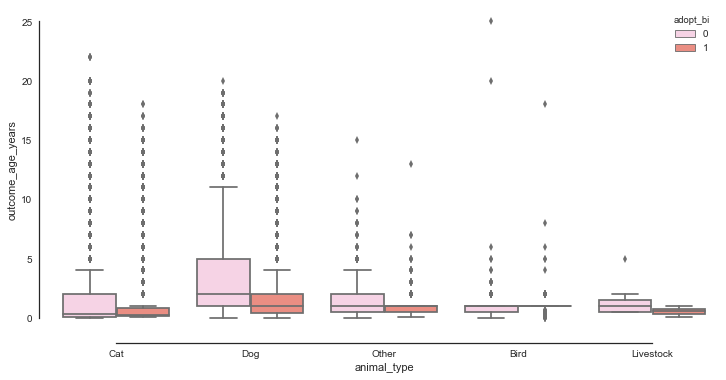

In [29]:
plt.figure(figsize=(12,6))
sns.boxplot(x="animal_type", y="outcome_age_years",hue="adopt_bi", data=raw_data, palette="Set3_r")
sns.despine(offset=10, trim=True)

Interesting.. It looks like animals that are adopted tend to be younger, compared to animals with other outcome types  The median age for dogs getting transfered, adopted, and euthanized is higher than that of the cats. Just looking at these boxplots, I would anticipate that the age of the animal is an important predictor of outcome type.

<a id='time'></a>
### Outcome times
I have a theory that adoptions are more likely to happen in certain times of the year and maybe even certain times of the week. I need to build additional features to capture the times of outcomes.

In [30]:
# Converting 'datetime' column into readable date and times.
raw_data['datetime'] = pd.to_datetime(raw_data['datetime'])

# Extracting month and year data.
raw_data['outcome_month'] = raw_data['datetime'].dt.month
raw_data['outcome_year'] = raw_data['datetime'].dt.year
raw_data['outcome_weekday'] = raw_data['datetime'].dt.weekday_name

# Adding additional season column
raw_data['outcome_season'] = np.where(raw_data['outcome_month'].between(3,5, inclusive=True), 'spring',
                                      np.where(raw_data['outcome_month'].between(6,8, inclusive=True), 'summer',
                                               np.where(raw_data['outcome_month'].between(9,11, inclusive=True), 'fall',
                                                        np.where(raw_data['outcome_month'].between(3,4, inclusive=True), 'spring','winter'))))

In [31]:
raw_data['outcome_year'].value_counts()

2014    18038
2015    17294
2017    16427
2016    16326
2013     4366
2018     1090
Name: outcome_year, dtype: int64

Looks like we have incomplete data for 2013 and 2018.  2013 could be when the shelter transferred information into a digital format.  2018 is still ongoing.  Both years contain a considerable amount of data so I won't remove them from the dataset.

In [32]:
raw_data['outcome_weekday'].value_counts()

Saturday     11665
Sunday       11373
Tuesday      10817
Monday       10579
Friday        9872
Wednesday     9761
Thursday      9474
Name: outcome_weekday, dtype: int64

There seems to be more activity, likely more adoptions, occuring on the weekends compared to weekdays.  

<a id='stage'></a>
### Life Stage
It is common knowledge that kittens and puppies are more likely to get adopted than adult cats and dogs, and senior dogs and cats are less likely to be adopted.  It may be useful to include a feature that distinguishes the animals by life stage.

In [33]:
# We are only considering cats and dogs here, so let's separate these two animal types 
#  into separate dataframes.  This will also be helpful when tackling the breed and color features.
cat_df = raw_data[raw_data['animal_type'] == 'Cat']
dog_df = raw_data[raw_data['animal_type'] == 'Dog']

In [34]:
# Kittens and puppies become adults at around 6 months, or 180 days.
cat_df['baby'] = np.where(cat_df['outcome_age_days'] < 180, 1, 0)
dog_df['baby'] = np.where(dog_df['outcome_age_days'] < 180, 1, 0)

# Cats and dogs generally become seniors at around 7 years.
cat_df['senior'] = np.where(cat_df['outcome_age_years'] >= 7, 1, 0)
dog_df['senior'] = np.where(dog_df['outcome_age_years'] >= 7, 1, 0)


<a id='breed'></a>
### Breed

#### Cats
Cat breeds are a little less complicated than dog breeds, so let's start there.  I am going to collect the breed data, create a separate column for cats with multiple breeds.  I am also creating a "Mix" column to distinguish whether or not the cat is mixed or purebred. Then I will use a list of breeds (according to the Cat Fancier Association) to determine if the cat is a recognized breed or domestic.

Inspiration on how to create the breed and color features can be found [here](https://aaronschlegel.me/extraction-feature-engineering-aac-data-requests-pandas.html)

In [35]:
cat_df.breed.value_counts()

Domestic Shorthair Mix                     22714
Domestic Medium Hair Mix                    2262
Domestic Longhair Mix                       1189
Siamese Mix                                  971
Domestic Shorthair                           379
American Shorthair Mix                       209
Snowshoe Mix                                 143
Domestic Medium Hair                         126
Maine Coon Mix                               100
Manx Mix                                      78
Russian Blue Mix                              61
Siamese                                       57
Domestic Longhair                             44
Himalayan Mix                                 28
Ragdoll Mix                                   22
Persian Mix                                   19
Siamese/Domestic Shorthair                    13
Angora Mix                                    12
Bengal Mix                                    12
Balinese Mix                                  10
Maine Coon          

In [36]:
cat_df['breed'] = cat_df['breed'].str.lower()

In [37]:
cat_df['mix'] = np.where(cat_df['breed'].str.contains("mix"), 1, 0)

In [38]:
# Creating a temporary breed_edit column.
# Dropping "mix", replacing "medium hair" with "mediumhair" for consistency, and lower-casing.

cat_df['breed_edit'] = cat_df['breed'].str.replace('mix', '').str.replace('medium hair', 'mediumhair').str.strip()       

According to the [Cat Fancier Association](http://cfa.org/Breeds.aspx), there are 42 cat breeds.  We will use these to recategorize our cat breeds.

In [39]:
cfa_breeds = ['Abyssinian', 'American Bobtail', 'American Curl', 'American Shorthair', 'American Wirehair', 
              'Balinese', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Burmese', 'Burmilla', 
              'Chartreux', 'Colorpoint Shorthair', 'Cornish Rex', 'Devon Rex', 'Egyptian Mau', 'European Burmese', 
              'Exotic', 'Havana Brown', 'Japanese Bobtail', 'Korat', 'LaPerm', 'Maine Coon', 'Manx', 
              'Norwegian Forest Cat', 'Ocicat', 'Oriental', 'Persian', 'Ragamuffin', 'Ragdoll', 'Russian Blue', 
              'Scottish Fold', 'Selkirk Rex', 'Siamese', 'Siberian', 'Singapura', 'Somali', 'Tonkinese', 
              'Turkish Angora', 'Turkish Van']

cfa_breeds = [i.lower() for i in cfa_breeds]
cfa_breeds = '|'.join(cfa_breeds)

cfa_breeds

'abyssinian|american bobtail|american curl|american shorthair|american wirehair|balinese|bengal|birman|bombay|british shorthair|burmese|burmilla|chartreux|colorpoint shorthair|cornish rex|devon rex|egyptian mau|european burmese|exotic|havana brown|japanese bobtail|korat|laperm|maine coon|manx|norwegian forest cat|ocicat|oriental|persian|ragamuffin|ragdoll|russian blue|scottish fold|selkirk rex|siamese|siberian|singapura|somali|tonkinese|turkish angora|turkish van'

Since some cats have two breeds, we will create a breed1 and breed2 column.
We will then distinguish whether the cat is a cfa recongized breed or domestic in separate features.  CFA breeds will hold precedence over the domestic breeds. (e.g. A Siamese/domestic shorthair will categorized as a cfa breed.)

In [40]:
# Splitting records with two breeds into two columns for each breed.
cat_df = pd.concat([cat_df, 
                     cat_df['breed_edit'].str.split('/', expand=True).rename(columns={0:'breed1', 1:'breed2'})], 
                    axis=1)

# If the columns is in the cfa list, mark as 1.
cat_df['cfa_breed'] = np.where((cat_df['breed1'].str.contains(cfa_breeds)) | 
                                (cat_df['breed2'].str.contains(cfa_breeds)), 
                                1, 0)

# If neither breed1 or breed2 columns contain a cfa recognized breed, mark as domestic.
cat_df['domestic_breed'] = np.where((cat_df['breed1'].str.contains(cfa_breeds) == False) | 
                                     (cat_df['breed2'].str.contains(cfa_breeds) == False), 
                                     1, 0)

#### Dogs
There are a lot more dog breeds than cat breeds.  339 dog breeds, to be exact.  It may be helpful to categorize whether or not the dog is a mix, along with the different breeds. 

In [41]:
dog_df.breed.value_counts()

Pit Bull Mix                                          5404
Chihuahua Shorthair Mix                               4502
Labrador Retriever Mix                                4213
German Shepherd Mix                                   1702
Australian Cattle Dog Mix                              974
Dachshund Mix                                          763
Boxer Mix                                              604
Miniature Poodle Mix                                   600
Border Collie Mix                                      586
Australian Shepherd Mix                                425
Catahoula Mix                                          420
Yorkshire Terrier Mix                                  420
Rat Terrier Mix                                        412
Jack Russell Terrier Mix                               388
Miniature Schnauzer Mix                                366
Siberian Husky Mix                                     363
Beagle Mix                                             3

In [42]:
# Lower-casing
dog_df['breed'] = dog_df['breed'].str.lower()

In [43]:
dog_df['mix'] = np.where(dog_df['breed'].str.contains("mix"), 1, 0)

In [44]:
# Dropping "mix" and stripping whitespace.

dog_df['breed_edit'] = dog_df['breed'].str.replace('mix', '').str.strip()  

# Splitting records with two breeds into two columns for each breed.
dog_df = pd.concat([dog_df, 
                     dog_df['breed_edit'].str.split('/', expand=True).rename(columns={0:'breed1', 1:'breed2'})], 
                    axis=1)

In [45]:
# A column was automatically generated for dogs with three listed breeds.  
# There are only 20 dogs with three listed breeds, so I will drop that column.
dog_df.drop(2, axis=1, inplace=True)

<a id='coat'></a>
### Coat - Color and Pattern

#### Cats
There are 231 combinations of colors and coat patterns.  There are sometimes two given colors, much like the breeds.  So we can handle color in similar ways.

In [46]:
cat_df.color.value_counts()

Brown Tabby                4334
Black                      3766
Black/White                2734
Brown Tabby/White          2250
Orange Tabby               2120
Tortie                     1308
Calico                     1266
Blue Tabby                 1100
Orange Tabby/White         1065
Blue                       1029
Torbie                      825
Blue/White                  774
Blue Tabby/White            524
White/Black                 487
Cream Tabby                 481
Lynx Point                  423
White                       327
Seal Point                  318
White/Brown Tabby           279
Cream Tabby/White           227
White/Blue                  189
Flame Point                 189
Black Tabby                 175
Torbie/White                171
Gray Tabby                  132
Black Smoke                 102
White/Orange Tabby          101
Lilac Point                  77
Gray                         73
Tortie/White                 72
                           ... 
White/Ye

There are coat patterns along with coat color in the data.  Let's pull this out in a separate column using a regex string and str.extract.

Inspiration for this method can be found [here](https://aaronschlegel.me/extraction-feature-engineering-aac-data-requests-pandas.html).

In [47]:
# Coat patterns for cats
coat_patterns = ['tabby', 'tortie', 'tortoiseshell', 'calico', 'smoke', 'torbie',
                 'colorpoint', 'point', 'brindle', 'agouti', 'bicolor', 'tricolor']

In [48]:
# Create the regex string by joining the coat patterns with | and encapsulating them in parantheses
coat_reg = '(' + '|'.join(coat_patterns) + ')'

coat_reg

'(tabby|tortie|tortoiseshell|calico|smoke|torbie|colorpoint|point|brindle|agouti|bicolor|tricolor)'

In [49]:
# Extracting coat pattern from color and removing it from color column
cat_df['color'] = cat_df['color'].str.lower()

cat_df['coat_pattern'] = cat_df['color'].str.extract(coat_reg, expand=False)

cat_df['color_edit'] = cat_df['color'].str.replace(coat_reg, '').str.strip()

Now we can split the cats with two colors into two color columns.
With coat patterns extracted, those without a listed color and only a listed coat pattern will be missing color data.  These now blank values signify breed-specific colors, so we can relabel them as such by searching for blanks in the color1 column and replacing it with 'breed specific'.

In [50]:
#Splitting color column into two color columns
cat_df = pd.concat([cat_df, 
                     cat_df['color_edit'].str.split('/', expand=True).rename(columns={0:'color1', 1:'color2'})], axis=1)

#Replacing blanks in color1 with 'breed specific'.
cat_df['color1'] = np.where(cat_df['color1'] == '', 'breed specific', cat_df['color1'])

# Creating a column that collects the extracted coat colors and patterns.  If the color is breed specific, list 
# the coat pattern.  Otherwise, list the color.
cat_df['coat'] = np.where(cat_df['color1'] == 'breed specific', cat_df['coat_pattern'], cat_df['color1'])

#### Dogs
Now for the dogs.  The dogs have 336 combinations of colors and coat patters.  We can treat it a similar way as we did for the cats.

In [51]:
dog_df.color.value_counts()

Black/White                    4596
Black                          2288
Tan/White                      2175
Brown/White                    2151
White                          2133
Tan                            1792
Tricolor                       1760
Brown                          1680
Black/Tan                      1654
White/Black                    1355
White/Brown                    1353
Black/Brown                    1261
Brown Brindle/White            1175
Blue/White                     1125
White/Tan                      1021
Brown/Black                     926
Red                             823
Red/White                       778
Brown Brindle                   662
Tan/Black                       542
Chocolate/White                 528
Yellow                          446
Sable                           404
Cream                           372
Buff                            352
Chocolate                       351
Fawn/White                      275
White/Brown Brindle         

These coat patterns are pulled from the Wikipedia page [here](https://en.wikipedia.org/wiki/Coat_(dog)).

In [52]:
# Coat patterns for dogs
coat_patterns = ['bicolor','tricolor','merle','tuxedo','harlequin','spotted','tick','brindle','saddle',
                'sable']

# Create the regex string by joining the coat patterns with | and encapsulating them in parantheses
coat_reg = '(' + '|'.join(coat_patterns) + ')'

coat_reg

'(bicolor|tricolor|merle|tuxedo|harlequin|spotted|tick|brindle|saddle|sable)'

In [53]:
# Extracting coat pattern from color and removing it from color column
dog_df['color'] = dog_df['color'].str.lower()

dog_df['coat_pattern'] = dog_df['color'].str.extract(coat_reg, expand=False)

dog_df['color_edit'] = dog_df['color'].str.replace(coat_reg, '').str.strip()

In [54]:
#Splitting color column into two color columns
dog_df = pd.concat([dog_df, 
                     dog_df['color_edit'].str.split('/', expand=True).rename(columns={0:'color1', 1:'color2'})], axis=1)

#Replacing blanks in color1 with 'breed specific'.
dog_df['color1'] = np.where(dog_df['color1'] == '', 'breed specific', dog_df['color1'])

# Creating a column that collects the extracted coat colors and patterns.  If the color is breed specific, list 
# the coat pattern.  Otherwise, list the color.
dog_df['coat'] = np.where(dog_df['color1'] == 'breed specific', dog_df['coat_pattern'], dog_df['color1'])

<a id='models'></a>
# Models
Let's start by seeing if we can predict overall outcomes of cats and dogs (separately) using our features.

In [55]:
# Dropping columns we don't need
cat_df2 = cat_df.drop(cat_df.iloc[:, 0:9], axis=1)
cat_df2 = cat_df2.drop(['sex_upon_outcome','number','time_period','breed_edit','color_edit','outcome_age_years'], axis=1)

In [56]:
# Dropping columns we don't need
dog_df2 = dog_df.drop(dog_df.iloc[:, 0:9], axis=1)
dog_df2 = dog_df2.drop(['sex_upon_outcome','number','time_period','breed_edit','color_edit','outcome_age_years'], axis=1)

In [57]:
# Also dropping outcome_subtype, which we will not be using for these models.
cat_df2 = cat_df2.drop(['outcome_subtype'], axis=1)
dog_df2 = dog_df2.drop(['outcome_subtype'], axis=1)

And, just so we don't have to deal with the NaNs in the data, we will just use the 'coat' column which shows the prominent coat pattern or coat color of the animal.  We will also just use breed1.

In [58]:
cat_df2 = cat_df2.drop(['breed2','coat_pattern','color1','color2'], axis=1)
dog_df2 = dog_df2.drop(['breed2','coat_pattern','color1','color2'], axis=1)

Below are the features we are going to use for building our models.

In [59]:
dog_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40337 entries, 1 to 78255
Data columns (total 15 columns):
outcome_type        40337 non-null object
adopt_bi            40337 non-null int64
name_bi             40337 non-null int64
male                40337 non-null int64
intact              40337 non-null int64
outcome_age_days    40337 non-null int64
outcome_month       40337 non-null int64
outcome_year        40337 non-null int64
outcome_weekday     40337 non-null object
outcome_season      40337 non-null object
baby                40337 non-null int64
senior              40337 non-null int64
mix                 40337 non-null int64
breed1              40337 non-null object
coat                40337 non-null object
dtypes: int64(10), object(5)
memory usage: 4.9+ MB


In [60]:
cat_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28627 entries, 0 to 78237
Data columns (total 17 columns):
outcome_type        28627 non-null object
adopt_bi            28627 non-null int64
name_bi             28627 non-null int64
male                28627 non-null int64
intact              28627 non-null int64
outcome_age_days    28627 non-null int64
outcome_month       28627 non-null int64
outcome_year        28627 non-null int64
outcome_weekday     28627 non-null object
outcome_season      28627 non-null object
baby                28627 non-null int64
senior              28627 non-null int64
mix                 28627 non-null int64
breed1              28627 non-null object
cfa_breed           28627 non-null int64
domestic_breed      28627 non-null int64
coat                28627 non-null object
dtypes: int64(12), object(5)
memory usage: 3.9+ MB


Let's take a quick peek at the correlation between our selected features and outcomes


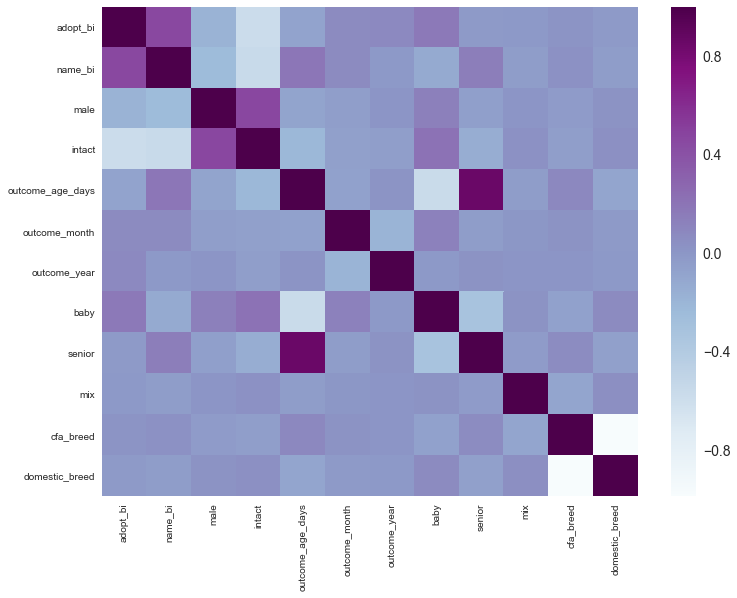

In [61]:
#Set up matplotlib
f, ax = plt.subplots(figsize=(12,9))
sns.set(font_scale=1.4)

sns.heatmap(cat_df2.corr(), cmap='BuPu')

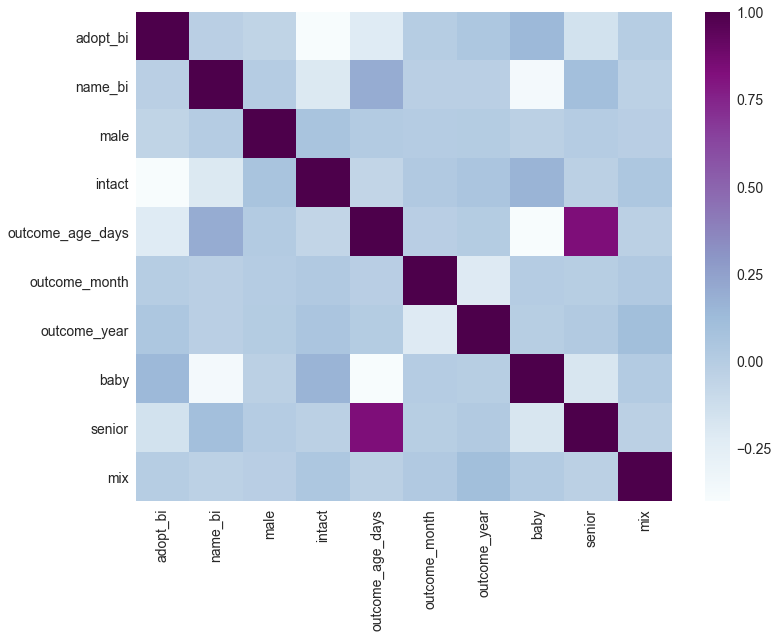

In [62]:
#Set up matplotlib
f, ax = plt.subplots(figsize=(12,9))
sns.set(font_scale=1.4)

sns.heatmap(dog_df2.corr(), cmap='BuPu')

Since some of the variables are binary, the correlation calculations are not exact.  But this still provides a nice overview of the feature correlations before we start building our models.

There are some correlations where we would expect, just based on how we defined our features.  'Senior' and 'Baby' is correlated with outcome_age_days because we used outcome_age_days to determine the lifestage of the animal.

We can also see here that cats with names are positively correlated with adopts, while names seem to be less correlated with adoption in dogs. In both cats and dogs, animals that are intact are negatively correlated with adoptions.  This is aligned with what we saw previously in the sex and outcome type [bar chart](#sexvoutcome).

<a id='tree'></a>
## Predicting adoption using a Decision Tree

Let's start by building and visualizing a Decision Tree for predicting adoption in cats.

### Cats

In [63]:
# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=4,
)

Since of our binary categories is treating 0 and 1 are integers, we need to change them to boolean values.

In [64]:
# Creating a copy of the cat dataframe for the boolean values
cat_df2a = cat_df2

In [65]:
bi_columns = ['name_bi','male','intact','baby','senior','mix','cfa_breed','domestic_breed','adopt_bi']
cat_df2a[bi_columns] = cat_df2a[bi_columns].astype(bool)

Let's also convert outcome year and month into strings

In [66]:
category_columns = ['outcome_month','outcome_year']
cat_df2a[category_columns] = cat_df2a[category_columns].astype(str)

Lastly, we will use a label encoder for the columns with strings and many categories

In [67]:
columns = ['breed1','coat','outcome_season','outcome_weekday']

def encoder(df):
    for col in columns:
        label_encoder = LabelEncoder()
        label_encoder.fit(df[col])
        df[col] = label_encoder.transform(df[col])
    return df

In [68]:
encoder(cat_df2a).head(5)

,outcome_type,adopt_bi,name_bi,male,intact,outcome_age_days,outcome_month,outcome_year,outcome_weekday,outcome_season,baby,senior,mix,breed1,cfa_breed,domestic_breed,coat
0,Transfer,False,False,True,True,14,7,2014,5,2,True,False,True,17,False,True,27
8,Adoption,True,True,False,True,30,8,2014,4,2,True,False,True,17,False,True,6
9,Adoption,True,True,False,False,90,6,2014,3,2,True,False,True,17,False,True,42
10,Return to Owner,False,True,False,False,365,3,2014,0,1,False,False,True,16,False,True,2
17,Transfer,False,False,True,True,21,1,2014,4,3,True,False,True,17,False,True,2


In [69]:
Xc = cat_df2a.drop(['outcome_type','adopt_bi'], 1)
yc = cat_df2a['adopt_bi']

decision_tree.fit(Xc, yc)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=1, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

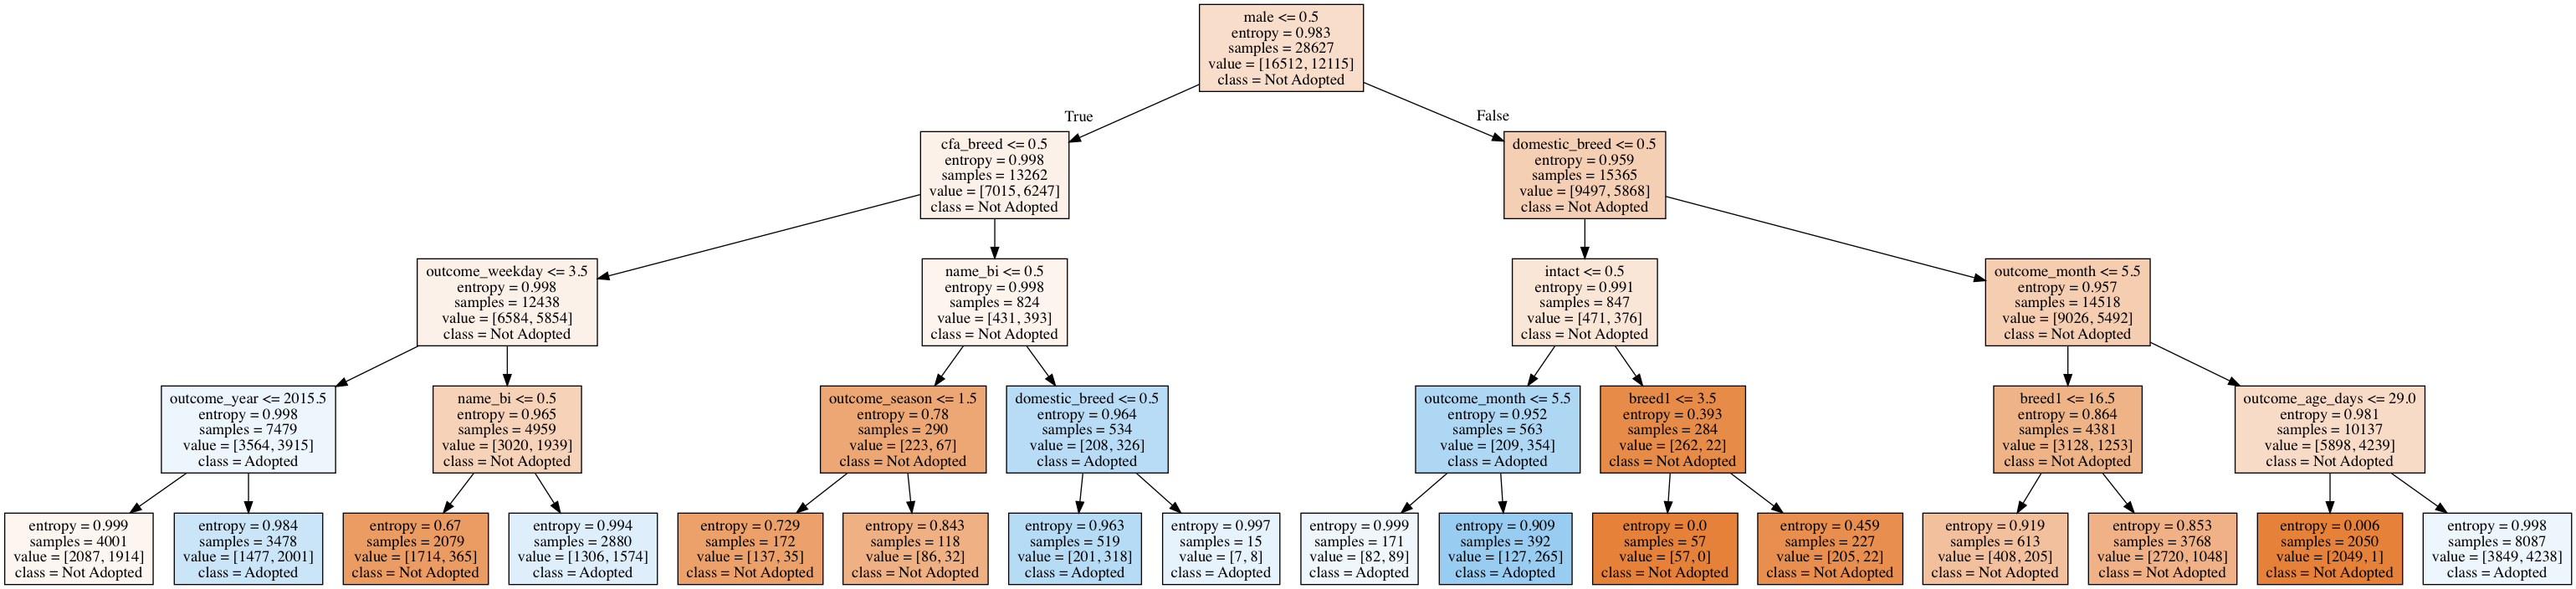

In [70]:
# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=Xc.columns,
    class_names=['Not Adopted', 'Adopted'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [71]:
decision_tree.score(Xc, yc)

0.62724001816466968

In [72]:
cross_val_score(decision_tree, Xc, yc, cv=5)

array([ 0.79776458,  0.68878798,  0.74777293,  0.57938865,  0.57746725])

The accuracy of the decision tree is okay though we are limiting it to four levels here for better visuals.  The accuracy would no doubt improve is we let the model run its full course.  The cross validations score are not very consistent here, however.  This indicates that the model is most likely overfitted.

### Dogs

In [73]:
dog_df2a = dog_df2

In [74]:
bi_columns = ['name_bi','male','intact','baby','senior','mix','adopt_bi']
dog_df2a[bi_columns] = dog_df2a[bi_columns].astype(bool)

In [75]:
category_columns = ['outcome_month','outcome_year']
dog_df2a[category_columns] = dog_df2a[category_columns].astype(str)

In [76]:
encoder(dog_df2a).head(5)

,outcome_type,adopt_bi,name_bi,male,intact,outcome_age_days,outcome_month,outcome_year,outcome_weekday,outcome_season,baby,senior,mix,breed1,coat
1,Transfer,False,True,False,False,365,11,2013,4,0,False,False,True,19,30
2,Adoption,True,True,True,False,365,6,2014,5,2,False,False,False,143,6
3,Transfer,False,True,True,False,3285,6,2014,3,2,False,True,True,125,30
5,Transfer,False,True,True,True,120,10,2013,1,0,True,False,True,116,11
7,Transfer,False,True,False,False,1095,12,2014,1,3,False,False,True,55,11


In [77]:
Xd = dog_df2.drop(['outcome_type','adopt_bi'], 1)
yd = dog_df2['adopt_bi']

decision_tree.fit(Xd, yd)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=1, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

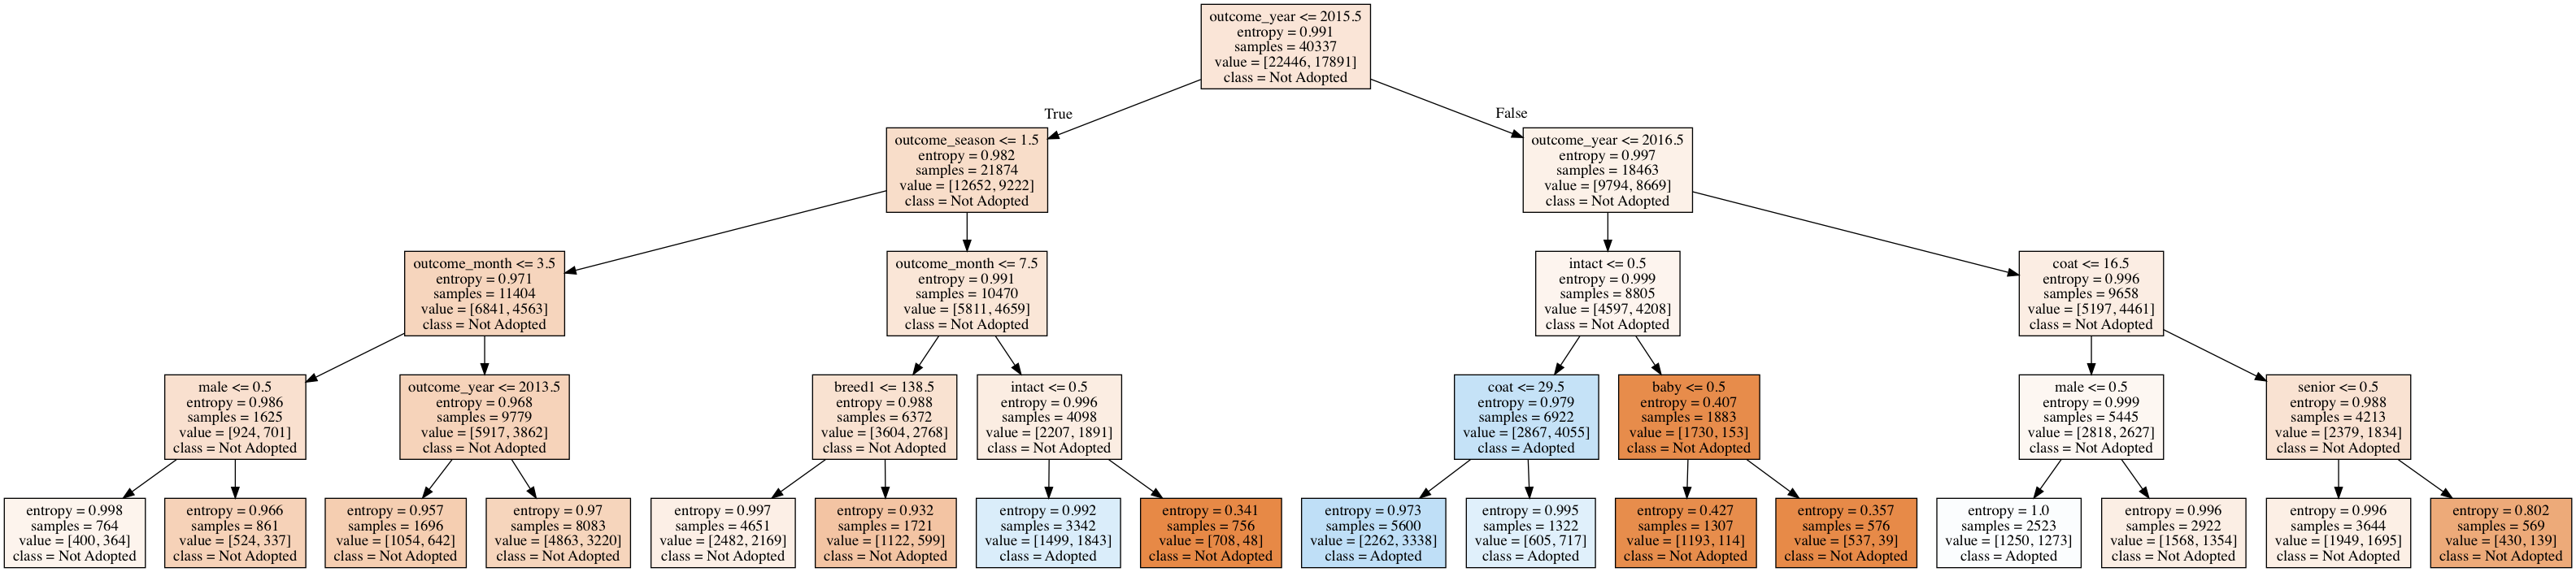

In [78]:
# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=Xd.columns,
    class_names=['Not Adopted', 'Adopted'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [79]:
decision_tree.score(Xd, yd)

0.5950120237003248

In [80]:
cross_val_score(decision_tree, Xd, yd, cv=5)

array([ 0.61655719,  0.60803273,  0.58881864,  0.59005826,  0.60208256])

There is some flucuation with the cross validation scores, though they are all above 0.50, indicating that the model is doing better than randomly guessing.  We can do better though.  Let's try generating Random Forest models.

<a id='foresto'></a>
## Predicting outcome using Random Forest
Let's see if we can use Random Forest to predict the outcomes of cats and dogs in the animal shelter.  Note that we are predicting outcome types in the following models, not adoption as a binary outcome.  I will generate the adoption binary model next.

### Cats

In [81]:
rfc = ensemble.RandomForestClassifier()
X = cat_df2.drop(['outcome_type','adopt_bi'], 1)
y = cat_df2['outcome_type']

# We need to get dummy variables for the categorical data
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=0, stratify=y)

In [82]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [83]:
rfc.score(X_test, y_test)

0.75596693445104202

In [84]:
cross_val_score(rfc, X, y, cv=5)

array([ 0.73346134,  0.73441592,  0.75619979,  0.75502359,  0.75830129])

In [85]:
y_pred = rfc.fit(X_train, y_train).predict(X_train)

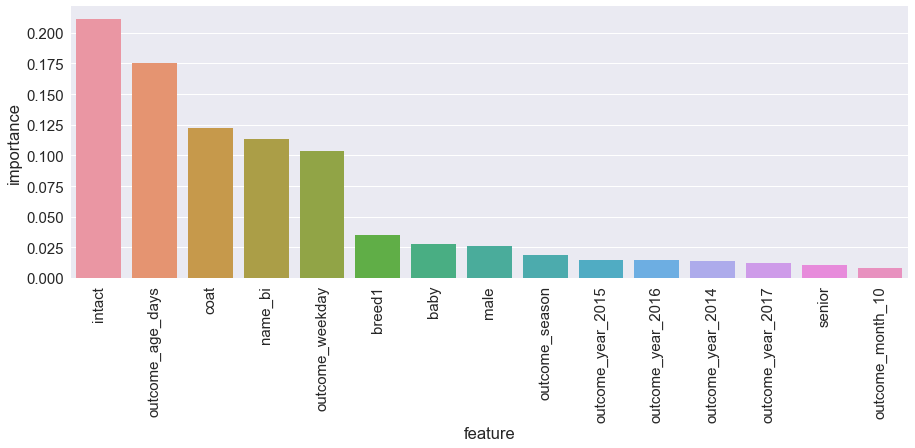

In [86]:
feature_importances = rfc.feature_importances_

importances = pd.DataFrame({'importance': feature_importances, 'feature': X.columns}, 
                           index=X.columns).sort_values(by='importance', ascending=False)

sns.set(font_scale=1.50)
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
sns.barplot(x='feature', y='importance', data=importances[0:15])

The accuracy score of this model is around 0.75, with consistent cross validation score. As we predicted with the exploratory data analysis, the age of the animal and whether or not the animal was fixed are important features when predicting shelter outcomes.  We can also see that 'coat' is the third most important feature, followed by what day of the week it is. Whether or not the cat has a name is also one of the top five features.

### Dogs
Let's try it for dogs!

In [87]:
rfc = ensemble.RandomForestClassifier()
X = dog_df2.drop(['outcome_type','adopt_bi'], 1)
y = dog_df2['outcome_type']

# We need to get dummy variables for the categorical data
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=0, stratify=y)

rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [88]:
rfc.score(X_test, y_test)

0.55932903652288879

In [89]:
cross_val_score(rfc, X, y, cv=10)

array([ 0.55189497,  0.53716551,  0.54187314,  0.53209418,  0.56530359,
        0.57040159,  0.5836846 ,  0.56288762,  0.56550868,  0.56079404])

Hmm the dog model does considerably worse than the cat model.  My theory is it is because of the high 'Return to owner' outcome for dogs.  I would imagine none of the features (dog breed, dog age, outcome time of year, etc) are good predictors to whether or not a dog is returned to the owner.  This would require further digging that we won't get into here.  

Let's take a look at feature importance.

In [90]:
y_pred = rfc.fit(X_train, y_train).predict(X_train)

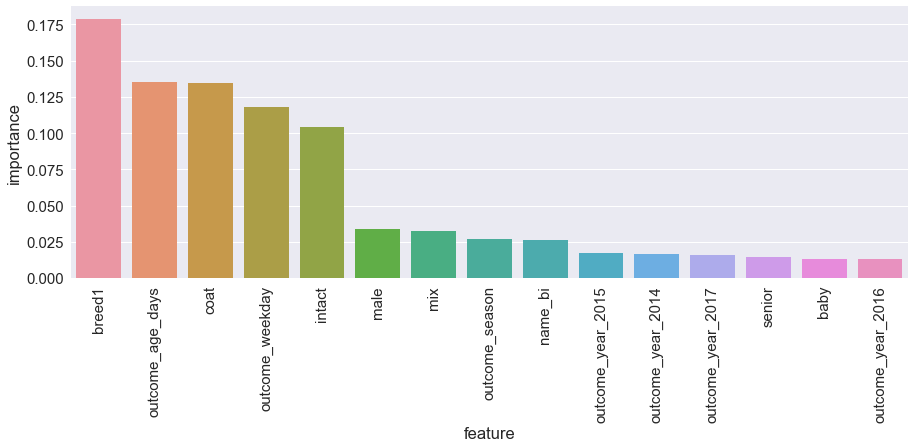

In [91]:
feature_importances = rfc.feature_importances_

importances = pd.DataFrame({'importance': feature_importances, 'feature': X.columns}, 
                           index=X.columns).sort_values(by='importance', ascending=False)

sns.set(font_scale=1.50)
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
sns.barplot(x='feature', y='importance', data=importances[0:15])

The top 5 outcomes do indeed look different for dogs compared to cats.  Notably, breed is much more important in dogs, which is not too surprising given that, historically, dogs are bred more selectively than cats were.  People tend to have more allegience to a certain breed to dog than breeds of cats. Also, whether or not the animal has a name is a better predictor for cats than it is for dogs. 

 <a id='foresta'></a>
## Predicting Adoption using Random Forest
What if we just want to look at whether or not the animal is adopted, compared to all other outcomes?  Here we are using the adoption binary outcome feature.

### Cats

In [92]:
rfc = ensemble.RandomForestClassifier()
Xc = cat_df2.drop(['outcome_type','adopt_bi'], 1)
yc = cat_df2['adopt_bi']

# We need to get dummy variables for the categorical data
Xc = pd.get_dummies(Xc)

Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.3,
                                                    random_state=0, stratify=yc)

rfc.fit(Xc_train, yc_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [93]:
rfc.score(Xc_test, yc_test)

0.84666433810688091

The model is more accurate when predicting whether or not a cat is adopted than distinguishing from the different outcome types.

In [94]:
cross_val_score(rfc, Xc, yc, cv=5)

array([ 0.82553266,  0.84212365,  0.85414847,  0.8431441 ,  0.85117904])

The cross validation shows consistent accuracy scores.

In [95]:
yc_pred = rfc.fit(Xc_train, yc_train).predict(Xc_train)

In [96]:
# Taking a look at the confusion matrix
conf_matrix = confusion_matrix(yc_train, yc_pred)
conf_matrix

array([[11421,   137],
       [  202,  8278]])

This array shows that there are slightly more false negatives (202 instances where the model predicted not adoption when it was an adoption) than false positive (137 instances where the model predicted adoption when it wasn't an adoption).  On the whole, the model looks to be fairly accurate.  Let's calcuate the sensitivity and specificity to be sure.

In [97]:
# Sensitivity of model: Percentage of positives correctly identified
print('The sensitivity is: ' + str(conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1])))

# Specificity of the model: Percentage of negatives correctly identified
print('The specificity is: ' + str(conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])))

The sensitivity is: 0.976179245283
The specificity is: 0.98814673819


The model has high sensitivity and specificity!  This means that the model is very good at predicting both adoptions and not adoptions.

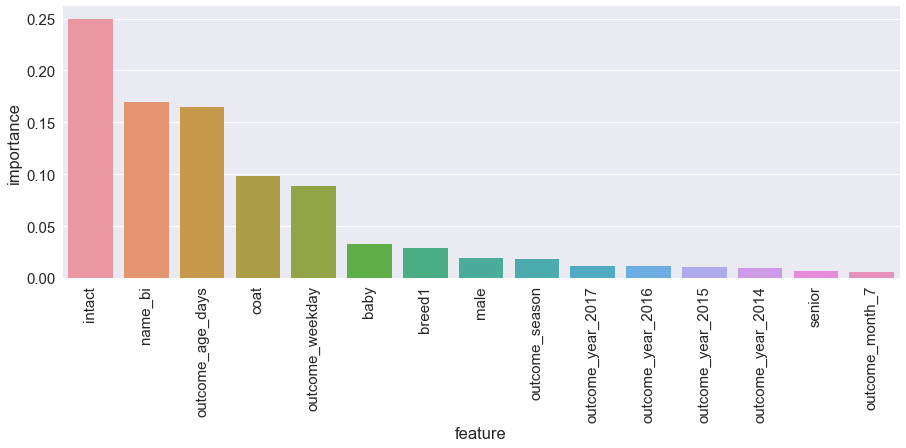

In [98]:
feature_importances = rfc.feature_importances_

importances = pd.DataFrame({'importance': feature_importances, 'feature': Xc.columns}, 
                           index=Xc.columns).sort_values(by='importance', ascending=False)

sns.set(font_scale=1.50)
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
sns.barplot(x='feature', y='importance', data=importances[0:15])

The top five features remained the same as when we were predicting cat outcomes, though in a slightly different order.  "Intact" is now the most important feature in determine whether or not a cat is adopted.  


### Dogs

In [99]:
rfc = ensemble.RandomForestClassifier()
Xd = dog_df2.drop(['outcome_type','adopt_bi'], 1)
yd = dog_df2['adopt_bi']

# We need to get dummy variables for the categorical data
Xd = pd.get_dummies(Xd)

Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=0.3,
                                                    random_state=0, stratify=yd)

rfc.fit(Xd_train, yd_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [100]:
rfc.score(Xd_test, yd_test)

0.70484217484713274

The accuracy for the model predicting whether or not the dog is adopted is much better compared to the model distinguishing the different outcome types.

In [101]:
cross_val_score(rfc, Xd, yd, cv=5)

array([ 0.67827488,  0.68811206,  0.7100533 ,  0.72331722,  0.71563159])

In [102]:
yd_pred = rfc.fit(Xd_train, yd_train).predict(Xd_train)

In [103]:
conf_matrix = confusion_matrix(yd_train, yd_pred)
conf_matrix

array([[15542,   170],
       [  388, 12135]])

Here, we have more false negatives (388 instancees where the model predicted not adoption when there was adoption) than false positives (170 instances where the model predicted adoption when it wasn't an adoption).  Let's look at the sensitivity and specificity.

In [104]:
# Sensitivity of model: Percentage of positives correctly identified
print('The sensitivity is: ' + str(conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1])))

# Specificity of the model: Percentage of negatives correctly identified
print('The specificity is: ' + str(conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])))

The sensitivity is: 0.969017008704
The specificity is: 0.989180244399


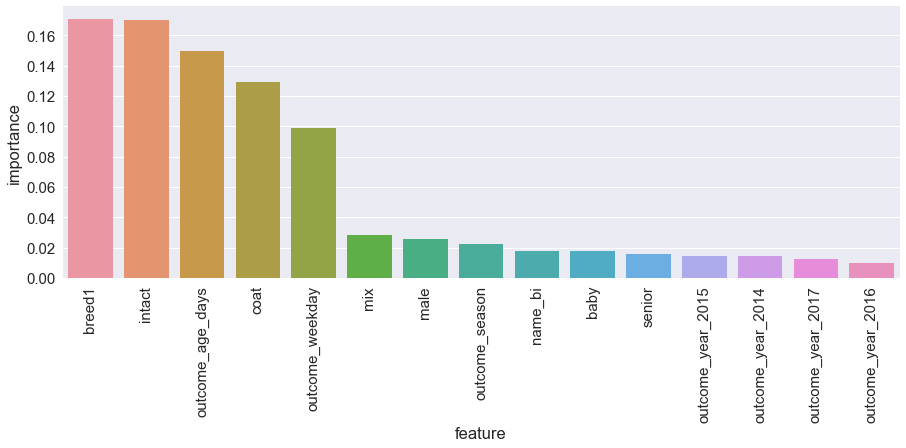

In [105]:
feature_importances = rfc.feature_importances_

importances = pd.DataFrame({'importance': feature_importances, 'feature': Xd.columns}, 
                           index=Xd.columns).sort_values(by='importance', ascending=False)

sns.set(font_scale=1.50)
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
sns.barplot(x='feature', y='importance', data=importances[0:15])

Same top five feature are doing most of the heavy lifting in this model, although in a different order. If the dog is intact or not plays a bigger role in determining adopt or not adopt.  Note that, in the cat model, there is a steady downward slope of feature importance.  For the dog model, the top 5 features informs the majority of the model. 



 <a id='svc'></a>
## Support Vector Machine for predicting adoption

To reduce the run time for our support vector machine, we are going to use a label encoder to assign the different breeds and coats to a number, instead of using dummy variables.

In [106]:
cat_df3 = encoder(cat_df2)
dog_df3 = encoder(dog_df2)

### Cats

In [107]:
Xc = cat_df3.drop(['outcome_type','adopt_bi'], 1)
yc = cat_df3['adopt_bi']

# We need to get dummy variables for the categorical data
#Xc = pd.get_dummies(Xc)

Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.3,
                                                    random_state=0, stratify=yc)

In [108]:
svc = SVC(C=1e-9, kernel='rbf')
svc.fit(Xc_train, yc_train)

SVC(C=1e-09, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [109]:
svc.score(Xc_test, yc_test)

0.57678425893584817

In [110]:
cross_val_score(svc, Xc, yc, cv=5)

array([ 0.57684247,  0.57684247,  0.57676856,  0.57676856,  0.57676856])

In [111]:
### Dogs

In [112]:
Xd = dog_df3.drop(['outcome_type','adopt_bi'], 1)
yd = dog_df3['adopt_bi']

# We need to get dummy variables for the categorical data
#Xd = pd.get_dummies(Xd)

Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=0.3,
                                                    random_state=0, stratify=yd)

In [113]:
svc = SVC(C=1e-9, kernel='rbf')
svc.fit(Xd_train, yd_train)

SVC(C=1e-09, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [114]:
svc.score(Xd_test, yd_test)

0.55643695256982317

In [115]:
cross_val_score(svc, Xd, yd, cv=5)

array([ 0.55645061,  0.55646461,  0.55646461,  0.55646461,  0.55646461])

While the LabelEncoder did reduce the runtime of the SVM, the accuracy of this model is not very high for either cats or dogs.  Let's employ Grid-search!

 <a id='grid'></a>
## SVM with Grid Search
There are two parameters for an RBF kernel of SVM: $C$ and $\gamma$.  The goal of grid search is to identify good ($C$ ,$\gamma$) that accurately predict unknown data (i.e. testing data). Using cross-validation, various pairs of ($C$, $\gamma$) are tried and the one with the best cross-validation accuracy is selected.

Helpful information on Grid-search here:
https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf

skLearn documentation here:
http://scikit-learn.org/stable/modules/grid_search.html

In [116]:
# First, let's generate a smaller dataset of 1000 data points for both cats and dogs

cat_df4 = cat_df3.sample(n=1000, random_state=42)
dog_df4 = cat_df3.sample(n=1000, random_state=42)

In [117]:
# Creating train and test data
X = cat_df4.drop(['outcome_type','adopt_bi'], 1)
y = cat_df4['adopt_bi']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=0, stratify=y)

Xd = dog_df4.drop(['outcome_type','adopt_bi'], 1)
yd = dog_df4['adopt_bi']

Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=0.3,
                                                    random_state=0, stratify=yd)

In [118]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Code adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
# Set the parameters by cross-validation
def gridsearch(X_train, y_train, X_test, y_test):
    
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9],
                     'C': [1, 10, 100, 1000, 10000]}]

    scores = ['precision', 'recall']

    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                           scoring='%s_macro' % score)
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()

In [119]:
gridsearch(X_train, y_train, X_test, y_test)

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'gamma': 1e-05, 'kernel': 'rbf', 'C': 10000}

Grid scores on development set:

0.734 (+/-0.020) for {'gamma': 0.001, 'kernel': 'rbf', 'C': 1}
0.740 (+/-0.020) for {'gamma': 0.0001, 'kernel': 'rbf', 'C': 1}
0.736 (+/-0.059) for {'gamma': 1e-05, 'kernel': 'rbf', 'C': 1}
0.362 (+/-0.196) for {'gamma': 1e-06, 'kernel': 'rbf', 'C': 1}
0.314 (+/-0.085) for {'gamma': 1e-07, 'kernel': 'rbf', 'C': 1}
0.293 (+/-0.000) for {'gamma': 1e-08, 'kernel': 'rbf', 'C': 1}
0.293 (+/-0.000) for {'gamma': 1e-09, 'kernel': 'rbf', 'C': 1}
0.717 (+/-0.044) for {'gamma': 0.001, 'kernel': 'rbf', 'C': 10}
0.728 (+/-0.025) for {'gamma': 0.0001, 'kernel': 'rbf', 'C': 10}
0.738 (+/-0.044) for {'gamma': 1e-05, 'kernel': 'rbf', 'C': 10}
0.462 (+/-0.381) for {'gamma': 1e-06, 'kernel': 'rbf', 'C': 10}
0.312 (+/-0.077) for {'gamma': 1e-07, 'kernel': 'rbf', 'C': 10}
0.293 (+/-0.000) for {'gamma': 1e-08, 'kernel': 'rbf', 'C': 10}
0.293

Great! It looks like $\gamma$ 1e-05 and $C$ 10000 yields that highest precision and recall.  Let's run those parameters on the full cat dataset.

In [120]:
svc = SVC(C=10000, gamma=1e-5, kernel='rbf')
svc.fit(Xc_train, yc_train)

SVC(C=10000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [121]:
svc.score(Xc_test, yc_test)

0.83746652695307955

In [122]:
cross_val_score(svc, Xc, yc, cv=5)

array([ 0.8365351 ,  0.83286762,  0.83475983,  0.82864629,  0.84331878])

Nice! We now have an accuracy of around 0.837.  This is about the same accuracy as Random Forest (0.849).

### Dogs

In [123]:
X = dog_df4.drop(['outcome_type','adopt_bi'], 1)
y = dog_df4['adopt_bi']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=0, stratify=y)

In [124]:
gridsearch(X_train, y_train, X_test, y_test)

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'gamma': 1e-05, 'kernel': 'rbf', 'C': 10000}

Grid scores on development set:

0.734 (+/-0.020) for {'gamma': 0.001, 'kernel': 'rbf', 'C': 1}
0.740 (+/-0.020) for {'gamma': 0.0001, 'kernel': 'rbf', 'C': 1}
0.736 (+/-0.059) for {'gamma': 1e-05, 'kernel': 'rbf', 'C': 1}
0.362 (+/-0.196) for {'gamma': 1e-06, 'kernel': 'rbf', 'C': 1}
0.314 (+/-0.085) for {'gamma': 1e-07, 'kernel': 'rbf', 'C': 1}
0.293 (+/-0.000) for {'gamma': 1e-08, 'kernel': 'rbf', 'C': 1}
0.293 (+/-0.000) for {'gamma': 1e-09, 'kernel': 'rbf', 'C': 1}
0.717 (+/-0.044) for {'gamma': 0.001, 'kernel': 'rbf', 'C': 10}
0.728 (+/-0.025) for {'gamma': 0.0001, 'kernel': 'rbf', 'C': 10}
0.738 (+/-0.044) for {'gamma': 1e-05, 'kernel': 'rbf', 'C': 10}
0.462 (+/-0.381) for {'gamma': 1e-06, 'kernel': 'rbf', 'C': 10}
0.312 (+/-0.077) for {'gamma': 1e-07, 'kernel': 'rbf', 'C': 10}
0.293 (+/-0.000) for {'gamma': 1e-08, 'kernel': 'rbf', 'C': 10}
0.293

Similar to the cat SVM, $\gamma$ 1e-05 and $C$ 10000 yields that highest precision and recall.  Let's run those parameters on the full dog dataset this time.

In [125]:
svc = SVC(C=10000, gamma=1e-5, kernel='rbf')
svc.fit(Xd_train, yd_train)

SVC(C=10000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [126]:
svc.score(Xd_test, yd_test)

0.81666666666666665

In [127]:
cross_val_score(svc, Xd, yd, cv=5)

array([ 0.82089552,  0.83      ,  0.805     ,  0.815     ,  0.80904523])

It looks like the accuracy for the SVM after the grid search (0.817) is better than the accuracy score for the dog random forest (0.704)!  Huzzah for grid search!  

 <a id='conclusion'></a>
 # Conclusion

For this capstone project, I wanted to build models that predict animal shelter outcomes in cats and dogs for the Austin Animal Shelter.  I engineered more precise features from our given dataset, including more robust categorization of sex, coat and breed.  With those features, I created Random Forest models that predicted shelter outcomes and whether or not the animal was adopted for cats and dogs.   I found that, for both predicting outcomes and predicting adoptions in cats, two features did most of the heavy-lifting: intact and outcome age in days.  The coat color/pattern, breed, and the day of the week of the outcome played less significant roles.  For dogs, however, five features prevail in the model: breed, intact, outcome age, coat, and outcome weekday.  One interesting finding was whether or not the animal has a name is a more important feature for determine adoption outcomes in cats than in dogs.  Conversely, the breed of the animal is a more important feature in dogs than cats. 

Both Random Forest and SVM models have high accuracies in predicting adoption. The accuracy scores for cats and dogs in the Random Forest models are 0.847 and 0.704, respectively.  Accuracy scores for cats and dogs in the SVM models, after employing grid search, is 0.837 and 0.817, respectively.  As both models provide accurate predictions on adoption outcomes, I would prefer the Random Forest model over the SVM model.  With Random Forest, we are better able to gain insights into the features that are most important in determining adoption outcomes, which we can better translate into action.